In [1]:
# Imports
import mmcv
import mmengine
import numpy as np
import torch, torchvision

import os
import os.path as osp

import cv2
import matplotlib.pyplot as plt
from PIL import Image

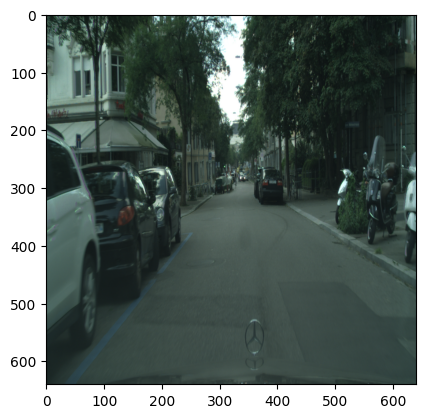

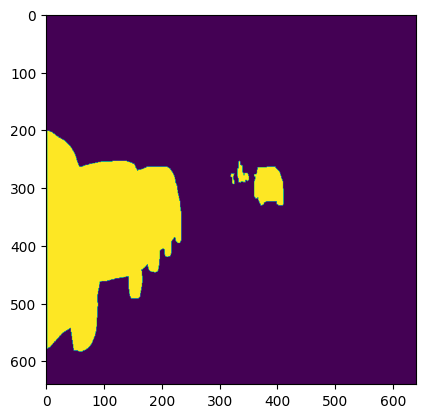

In [2]:
imgs_dir = "task/dataset/imgs"
sem_seg_dir = "task/dataset/gt_sem_seg"

def get_img_and_gt(index):
    img = cv2.imread(os.path.join(imgs_dir, f"{index:06d}.png"))
    sem_seg = cv2.imread(os.path.join(sem_seg_dir, f"{index:06d}.png"), cv2.IMREAD_GRAYSCALE)
    return img, sem_seg

pics = [100,200,400,500]
for img_index in pics:
    img, sem_seg = get_img_and_gt(img_index)

plt.figure()
_ = plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.figure()
_ = plt.imshow(sem_seg)

In [5]:
# define dataset root and directory for images and annotations
data_root = 'task/dataset'
img_dir = 'imgs'
ann_dir = 'new_gt_sem_seg'
# define class and palette for better visualization
classes = ('background', 'car')
palette = [[0, 0, 0], [255, 0, 0]]

In [6]:
new_dir = 'final_gt_sem_seg'
for file in mmengine.scandir(os.path.join(data_root, ann_dir), suffix='.png'):
    seg_map = np.array(Image.open(os.path.join(data_root, ann_dir, file)).convert('L'))
    seg_img = Image.fromarray(seg_map).convert('P')
    seg_img.putpalette(np.array(palette, dtype=np.uint8))
    seg_img.save(os.path.join(data_root, new_dir, file))

ann_dir = new_dir

In [7]:
# split train/val set randomly
split_dir = 'splits'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = int(len(filename_list)*4/5)
  f.writelines(line + '\n' for line in filename_list[:train_length])

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [8]:
img = cv2.imread('task/dataset/final_gt_sem_seg/000002.png', 0)

h, w = img.shape[:2]
res = {}
for i in range(h):
    for j in range(w):
        v = img[i][j]
        if v in res.keys():
            res[v] += 1
        else:
            res[v] = 1
pprint(res)

{0: 396294, 255: 13306}


In [9]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class Car3Dataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', 
                     seg_map_suffix='.png', 
                     reduce_zero_label=False,
                     **kwargs)

In [10]:
# Download config and checkpoint files
!mim download mmsegmentation --config pspnet_r50-d8_4xb2-40k_cityscapes-512x1024 --dest .

processing pspnet_r50-d8_4xb2-40k_cityscapes-512x1024...
pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth exists in /home/vagabond/Documents/mmcv-test
Successfully dumped pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py to /home/vagabond/Documents/mmcv-test


In [11]:
from mmengine import Config
cfg = Config.fromfile('pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'data/cityscapes/'
dataset_type = 'CityscapesDataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=4000, type='CheckpointHook'),
    logger=dict(interval=50, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.

In [12]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
#cfg.crop_size = (64, 64)
cfg.crop_size = (512, 1024)
#cfg.model.data_preprocessor.size = cfg.crop_size
cfg.model.backbone.norm_cfg = cfg.norm_cfg
cfg.model.decode_head.norm_cfg = cfg.norm_cfg
cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 2
cfg.model.decode_head.out_channels = 2
cfg.model.decode_head.threshold = 0.3
#cfg.model.decode_head.ignore_index = 0
cfg.model.decode_head.loss_decode.use_sigmoid=False

cfg.model.auxiliary_head.num_classes = 2
cfg.model.auxiliary_head.out_channels = 2
cfg.model.decode_head.loss_decode.use_sigmoid=False


# Modify dataset type and path
cfg.dataset_type = 'Car3Dataset'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 2

'''# This img_norm_cfg is widely used because it is mean and std of ImageNet 1K pretrained model
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PackSegInputs')
]

cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(320, 240), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations', reduce_zero_label=False),
    dict(type='PackSegInputs')
]
'''

"# This img_norm_cfg is widely used because it is mean and std of ImageNet 1K pretrained model\nimg_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)\n\ncfg.train_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(type='LoadAnnotations', reduce_zero_label=False),\n    dict(type='RandomResize', scale=(320, 240), ratio_range=(0.5, 2.0), keep_ratio=True),\n    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),\n    dict(type='RandomFlip', prob=0.5),\n    dict(type='PackSegInputs')\n]\n\ncfg.test_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(type='Resize', scale=(320, 240), keep_ratio=True),\n    # add loading annotation after ``Resize`` because ground truth\n    # does not need to do resize data transform\n    dict(type='LoadAnnotations', reduce_zero_label=False),\n    dict(type='PackSegInputs')\n]\n"

In [13]:
'''img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
cfg.img_scale = (640, 640)
cfg.crop_size = (64, 64)
cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', scale=cfg.img_scale, ratio_range=(0.5, 2.0)),
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg'])
]
cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=cfg.img_scale,
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='DefaultFormatBundle'),
            dict(type='Collect', keys=['img'])
        ])
]'''

"img_norm_cfg = dict(\n    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)\ncfg.img_scale = (640, 640)\ncfg.crop_size = (64, 64)\ncfg.train_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(type='LoadAnnotations'),\n    dict(type='Resize', scale=cfg.img_scale, ratio_range=(0.5, 2.0)),\n    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=0.75),\n    dict(type='RandomFlip', prob=0.5),\n    dict(type='PhotoMetricDistortion'),\n    dict(type='Normalize', **img_norm_cfg),\n    dict(type='Pad', size=cfg.crop_size, pad_val=0, seg_pad_val=255),\n    dict(type='DefaultFormatBundle'),\n    dict(type='Collect', keys=['img', 'gt_semantic_seg'])\n]\ncfg.test_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(\n        type='MultiScaleFlipAug',\n        img_scale=cfg.img_scale,\n        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75, 2.0],\n        flip=False,\n        transforms=[\n            dict(type='Resize', keep_ratio=True),\n        

In [14]:
'''import albumentations as A
from albumentations.pytorch import ToTensorV2
transform=A.Compose(
[
    A.Resize(256, 512),
    A.HorizontalFlip(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
]
)'''

'import albumentations as A\nfrom albumentations.pytorch import ToTensorV2\ntransform=A.Compose(\n[\n    A.Resize(256, 512),\n    A.HorizontalFlip(),\n    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),\n    ToTensorV2(),\n]\n)'

In [15]:
'''img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (64, 64)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='Resize', scale=(256, 512), ratio_range=(0.5, 2.0)),
    dict(type='HorizontalFlip', flip_ratio=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size=crop_size, pad_val=0, seg_pad_val=255),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug',
        img_scale=(512, 1024),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]'''

"img_norm_cfg = dict(\n    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)\ncrop_size = (64, 64)\ntrain_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(type='LoadAnnotations'),\n    dict(type='Resize', scale=(256, 512), ratio_range=(0.5, 2.0)),\n    dict(type='HorizontalFlip', flip_ratio=0.5),\n    dict(type='PhotoMetricDistortion'),\n    dict(type='Normalize', **img_norm_cfg),\n    dict(type='Pad', size=crop_size, pad_val=0, seg_pad_val=255),\n    dict(type='DefaultFormatBundle'),\n    dict(type='Collect', keys=['img', 'gt_semantic_seg']),\n]\ntest_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(type='MultiScaleFlipAug',\n        img_scale=(512, 1024),\n        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],\n        flip=False,\n        transforms=[\n            dict(type='Resize', keep_ratio=True),\n            dict(type='RandomFlip'),\n            dict(type='Normalize', **img_norm_cfg),\n            dict(type='ImageToTensor', keys=[

In [16]:
'''_base_ = './cityscapes.py'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
crop_size = (640, 640)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_semantic_seg']),
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(640, 640),
        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],
        flip=False,
        transforms=[
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),
        ])
]
data = dict(
    train=dict(pipeline=train_pipeline),
    val=dict(pipeline=test_pipeline),
    test=dict(pipeline=test_pipeline))'''

"_base_ = './cityscapes.py'\nimg_norm_cfg = dict(\n    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)\ncrop_size = (640, 640)\ntrain_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(type='LoadAnnotations'),\n    dict(type='DefaultFormatBundle'),\n    dict(type='Collect', keys=['img', 'gt_semantic_seg']),\n]\ntest_pipeline = [\n    dict(type='LoadImageFromFile'),\n    dict(\n        type='MultiScaleFlipAug',\n        img_scale=(640, 640),\n        # img_ratios=[0.5, 0.75, 1.0, 1.25, 1.5, 1.75],\n        flip=False,\n        transforms=[\n            dict(type='ImageToTensor', keys=['img']),\n            dict(type='Collect', keys=['img']),\n        ])\n]\ndata = dict(\n    train=dict(pipeline=train_pipeline),\n    val=dict(pipeline=test_pipeline),\n    test=dict(pipeline=test_pipeline))"

In [17]:
'''
cfg.data = dict(
    samples_per_gpu=4,
    workers_per_gpu=4,
    train_dataloader=dict(
        type='RepeatDataset',
        times=40000,
        dataset=dict(
            type=cfg.dataset_type,
            data_root=cfg.data_root,
            data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir),
            ann_file='splits/train.txt',
            pipeline=cfg.train_pipeline)),
    test_dataloader=dict(
        type=cfg.dataset_type,
        data_root=cfg.data_root,
        data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir),
        ann_file='splits/val.txt',
        pipeline=cfg.test_pipeline))'''

"\ncfg.data = dict(\n    samples_per_gpu=4,\n    workers_per_gpu=4,\n    train_dataloader=dict(\n        type='RepeatDataset',\n        times=40000,\n        dataset=dict(\n            type=cfg.dataset_type,\n            data_root=cfg.data_root,\n            data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir),\n            ann_file='splits/train.txt',\n            pipeline=cfg.train_pipeline)),\n    test_dataloader=dict(\n        type=cfg.dataset_type,\n        data_root=cfg.data_root,\n        data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir),\n        ann_file='splits/val.txt',\n        pipeline=cfg.test_pipeline))"

In [18]:

cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = 'splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = 'splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader

# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/test_1'

cfg.train_cfg.max_iters = 200
cfg.train_cfg.val_interval = 200
cfg.default_hooks.logger.interval = 10
cfg.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'task/dataset'
dataset_type = 'Car3Dataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_

In [19]:
# Visualize 
#cfg.default_hooks = dict(
#    timer=dict(type='IterTimerHook'),
#    logger=dict(type='LoggerHook', interval=50, log_metric_by_epoch=False),
#    param_scheduler=dict(type='ParamSchedulerHook'),
#    checkpoint=dict(type='CheckpointHook', by_epoch=False, interval=2000),
#    sampler_seed=dict(type='DistSamplerSeedHook'),
#    visualization=dict(type='SegVisualizationHook', draw=True, interval=1))


In [20]:
import gc
gc.collect()
torch.cuda.empty_cache()

#from numba import cuda
#cuda.select_device(0)
#cuda.close()
#cuda.select_device(0)

In [21]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

05/22 19:16:51 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
    CUDA available: True
    MUSA available: False
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3080 Ti
    CUDA_HOME: /usr/local/cuda-12
    NVCC: Cuda compilation tools, release 12.4, V12.4.99
    GCC: x86_64-linux-gnu-gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.3.0+cu121
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v3.3.6 (Git Hash 86e6af5974177e513fd3fee58425e1063e7f1361)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 12.1
  - NVCC architecture flags: -gencode;arch=compute

/home/vagabond/Documents/mmcv-test/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '
/home/vagabond/Documents/mmcv-test/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


05/22 19:16:52 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/22 19:16:52 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/vagabond/Documents/mmcv-test/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [1]:
print(torch.cuda.memory_summary())

NameError: name 'torch' is not defined

In [23]:
# start training
runner.train()

05/22 19:16:52 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
05/22 19:16:52 - mmengine - INFO - load model from: open-mmlab://resnet50_v1c
05/22 19:16:52 - mmengine - INFO - Loads checkpoint by openmmlab backend from path: open-mmlab://resnet50_v1c
05/22 19:16:52 - mmengine - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: fc.weight, fc.bias

Loads checkpoint by local backend from path: pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth
The model and loaded state dict do not match exactly

size mismatch for decode_head.conv_seg.weight: copying a param with shape torch.Size([19, 512, 1, 1]) from checkpoint, the shape in current model is torch.Size([2, 512, 1, 1]).
size mismatch for decode_head.conv_seg.bias: copying a param with shape torch.Size([19]) from checkpoint, the shape in current model is torch.Size([2]).
size mismatch for auxiliary_head.conv_seg.weight: copying a param with shape tor

EncoderDecoder(
  (data_preprocessor): SegDataPreProcessor()
  (backbone): ResNetV1c(
    (stem): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU(inplace=True)
    )
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): ResLayer(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-0

/home/vagabond/Documents/mmcv-test/mmsegmentation/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


Loads checkpoint by local backend from path: work_dirs/test_1/iter_200.pth


/home/vagabond/Documents/mmcv-test/venv/lib/python3.10/site-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


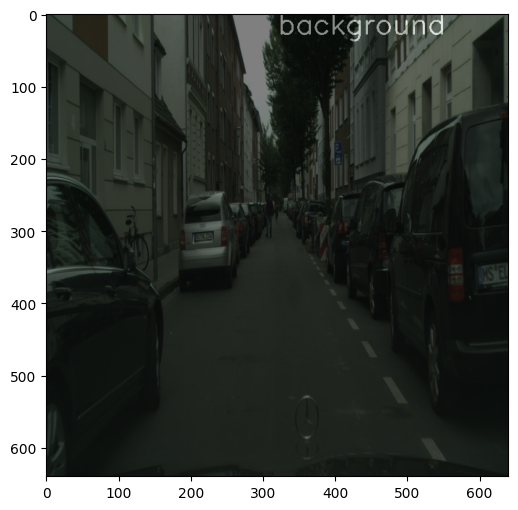

In [24]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = 'work_dirs/test_1/iter_200.pth'
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread('task/dataset/imgs/000033.png')
result = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, result)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [28]:
# split train/val set randomly
split_dir = 'splits2'
mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
    osp.join(data_root, ann_dir), suffix='.png')]

with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
  # select first 4/5 as train set
  train_length = 0
  f.writelines(line + '\n' for line in filename_list[:train_length])

with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
  # select last 1/5 as train set
  f.writelines(line + '\n' for line in filename_list[train_length:])

In [29]:
@DATASETS.register_module()
class CarTestDataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', 
                     seg_map_suffix='.png', 
                     reduce_zero_label=False,
                     **kwargs)

In [41]:
from mmengine import Config
from mmengine.runner import Runner

cfg2 = Config.fromfile('pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
cfg2.dataset_type = 'Car3Dataset'
cfg2.data_root = data_root

cfg2.train_dataloader.batch_size = 2
# Set up working dir to save files and logs.
cfg2.work_dir = './work_dirs/test_2'

cfg2.val_dataloader.dataset.type = cfg2.dataset_type
cfg2.val_dataloader.dataset.data_root = cfg2.data_root
cfg2.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg2.val_dataloader.dataset.pipeline = cfg2.test_pipeline
cfg2.val_dataloader.dataset.ann_file = 'splits2/val.txt'

cfg2.test_dataloader = cfg2.val_dataloader

cfg2.train_cfg.max_iters = 200
cfg2.train_cfg.val_interval = 200
cfg2.default_hooks.logger.interval = 10
cfg2.default_hooks.checkpoint.interval = 200

# Set seed to facilitate reproducing the result
cfg2['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
print(f'Config:\n{cfg2.pretty_text}')

runner = Runner.from_cfg(cfg2)

Config:
crop_size = (
    512,
    1024,
)
data_preprocessor = dict(
    bgr_to_rgb=True,
    mean=[
        123.675,
        116.28,
        103.53,
    ],
    pad_val=0,
    seg_pad_val=255,
    size=(
        512,
        1024,
    ),
    std=[
        58.395,
        57.12,
        57.375,
    ],
    type='SegDataPreProcessor')
data_root = 'task/dataset'
dataset_type = 'Car3Dataset'
default_hooks = dict(
    checkpoint=dict(by_epoch=False, interval=200, type='CheckpointHook'),
    logger=dict(interval=10, log_metric_by_epoch=False, type='LoggerHook'),
    param_scheduler=dict(type='ParamSchedulerHook'),
    sampler_seed=dict(type='DistSamplerSeedHook'),
    timer=dict(type='IterTimerHook'),
    visualization=dict(type='SegVisualizationHook'))
default_scope = 'mmseg'
env_cfg = dict(
    cudnn_benchmark=True,
    dist_cfg=dict(backend='nccl'),
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0))
img_ratios = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
]
load_

/home/vagabond/Documents/mmcv-test/venv/lib/python3.10/site-packages/mmengine/utils/manager.py:113: UserWarning: <class 'mmseg.visualization.local_visualizer.SegLocalVisualizer'> instance named of visualizer has been created, the method `get_instance` should not accept any other arguments
  warnings.warn(
/home/vagabond/Documents/mmcv-test/mmsegmentation/mmseg/models/backbones/resnet.py:431: UserWarning: DeprecationWarning: pretrained is a deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is a deprecated, '


05/22 19:25:02 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
05/22 19:25:02 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/vagabond/Documents/mmcv-test/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:60: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [42]:
runner.test()

05/22 19:25:24 - mmengine - WARNING - The prefix is not set in metric class IoUMetric.
05/22 19:25:25 - mmengine - INFO - Iter(test) [  10/3311]    eta: 0:04:49  time: 0.0878  data_time: 0.0097  memory: 1906  
05/22 19:25:26 - mmengine - INFO - Iter(test) [  20/3311]    eta: 0:04:31  time: 0.0769  data_time: 0.0013  memory: 1718  
05/22 19:25:27 - mmengine - INFO - Iter(test) [  30/3311]    eta: 0:04:24  time: 0.0770  data_time: 0.0012  memory: 1718  
05/22 19:25:28 - mmengine - INFO - Iter(test) [  40/3311]    eta: 0:04:20  time: 0.0772  data_time: 0.0013  memory: 1718  
05/22 19:25:28 - mmengine - INFO - Iter(test) [  50/3311]    eta: 0:04:18  time: 0.0773  data_time: 0.0012  memory: 1718  
05/22 19:25:29 - mmengine - INFO - Iter(test) [  60/3311]    eta: 0:04:16  time: 0.0776  data_time: 0.0011  memory: 1718  
05/22 19:25:30 - mmengine - INFO - Iter(test) [  70/3311]    eta: 0:04:15  time: 0.0772  data_time: 0.0011  memory: 1718  
05/22 19:25:31 - mmengine - INFO - Iter(test) [  80/

{'aAcc': 0.0, 'mIoU': 0.0, 'mAcc': 0.0}

In [ ]:
import cv2
from pprint import pprint

input_path = "task/dataset/gt_sem_seg_1/*"
images = glob.glob(input_path)

for pic in images:
    img = cv2.imread(pic, 0)

    h, w = img.shape[:2]
    res = {}
    for i in range(h):
        for j in range(w):
            v = img[i][j]
            if v in res.keys():
                res[v] += 1
            else:
                res[v] = 1
    if len(res) != 2:
        pprint(res)

In [ ]:
from mmengine import Config
from mmengine.runner import Runner

cfg = Config.fromfile('pspnet_r50-d8_4xb2-40k_cityscapes-512x1024.py')
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
# define dataset root and directory for images and annotations
data_root = 'task/dataset'
labels_directory = 'gt_sem_seg_13'
predictions_directory = 'output'
img_dir = 'imgs'
ann_dir = 'gt_sem_seg'
# define class and palette for better visualization
classes = ('background', 'car')
palette = [[0, 0, 0], [0, 0, 142]]

In [ ]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

@DATASETS.register_module()
class Car3Dataset(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', 
                     seg_map_suffix='.png', 
                     reduce_zero_label=False,
                     **kwargs)

In [ ]:
# Since we use only one GPU, BN is used instead of SyncBN
cfg.norm_cfg = dict(type='BN', requires_grad=True)
# Modify dataset type and path
cfg.dataset_type = 'Car3Dataset'
cfg.data_root = data_root

cfg.test_dataloader.batch_size = 2
cfg.test_dataloader.dataset.type = cfg.dataset_type
cfg.test_dataloader.dataset.data_root = cfg.data_root
cfg.test_dataloader.dataset.data_prefix = dict(img_path=labels_directory, seg_map_path=predictions_directory)
#cfg.test_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.test_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.test_dataloader.dataset.ann_file = 'splits2/val.txt'
cfg.test_pipeline = []

#cfg.test_evaluator= dict(type='CityscapesMetric', output_dir='tmp')

# Load the pretrained weights
cfg.load_from = 'pspnet_r50-d8_512x1024_40k_cityscapes_20200605_003338-2966598c.pth'

# Set up working dir to save files and logs.
cfg.work_dir = './work_dirs/test_123'

In [ ]:
print(f'Config:\n{cfg.pretty_text}')

In [ ]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

runner.test()